In [54]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

#set datadir based on cwd
cwd = os.getcwd()
datadir = cwd + '/data/'
raw = pd.read_csv(datadir+'raw.csv')


<h3>Data Cleaning and Validation<h3/>

In [55]:
df = raw.set_index('defendantid')
df = df.drop(['NewArrests36','NewFelArrests36', 'NewMisdArrests36', 'NewViolArrests36','NewArrest36', 'NewFelArrest36', 'NewMisdArrest36', 'NewViolArrest36'],axis = 1)

#created binary target variable
#we are going to predict if the preson will commit a crime or not in the future 36 month
df = df.rename(columns={'NewArrest36Type':'NewArrest36'})
#classified target variable from multiclass to binary
df['NewArrest36'] = df['NewArrest36'].apply(lambda x:0 if x == 'None' else 1 )
df.head()

,gender,race,category,MajorGroupDetail,AgeAtFirst,OrderProtect,Housing,Age,MisdConviction,FelonyConviction,...,Prison,Incarcerations5,Jail5,Prison5,Incarcerations10,Jail10,Prison10,CareerLength,CvtDensity,NewArrest36
defendantid,,,,,,,,,,,,,,,,,,,,,
15372,M,Asian/Pacific Islander,Misdemeanor,UGV,NaN,0,0,32.0,0,0,...,0,0,0,0,0,0,0,NaN,NaN,0
16191,F,Black,Misdemeanor,Forged Instrument,30.0,0,0,42.0,0,0,...,0,0,0,0,0,0,0,12.0,0.000000,0
24,M,Black,Misdemeanor,Marijuana,23.0,1,0,30.0,1,0,...,0,4,4,0,4,4,0,8.0,0.866025,1
959,M,Black-Hispanic,Misdemeanor,Drugs,33.0,0,1,54.0,1,1,...,1,4,4,0,11,11,0,23.0,1.693979,1
1596,M,Black,Felony,Grand Larceny,18.0,0,0,24.0,1,1,...,0,2,2,0,2,2,0,7.0,0.845154,1


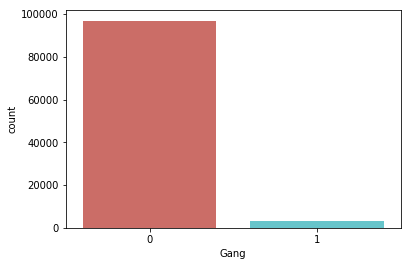

In [56]:
#Feature Reduction
#Step 1: drop all columns with 10 and 9. We only look at data within 5 years
for i in df.columns:
    if '10' in i or '9' in i:
        df = df.drop(i,axis = 1)
        
#Step 2: drop features based on domain knowledge
df = df.drop(['CareerLength','MajorGroupDetail','CvtTypes'],axis = 1)

#Step 3: drop features by plotting
sns.countplot(x='Gang',data = df,palette='hls')
plt.show()

In [57]:
df = df.drop('Gang',axis = 1)

In [67]:
df['race'] = df['race'].apply(lambda x: 'Unknown' if x == 'Unsure' else x)

array(['Asian/Pacific Islander', 'Black', 'Black-Hispanic',
       'White-Hispanic', 'White', 'Unknown',
       'American Indian/Alaskan Native', nan], dtype=object)

In [68]:
#check missing value
df.isnull().sum()

gender                   0
race                     4
category               191
AgeAtFirst           47661
OrderProtect             0
Housing                  0
Age                    147
MisdConviction           0
FelonyConviction         0
ViolentConviction        0
ViolentOffense           0
BWO24                    0
BWO24Plus                0
Arrests                  0
FelArrests               0
MisdArrests              0
ViolArrests              0
Arrests5                 0
FelArrests5              0
MisdArrests5             0
ViolArrests5             0
Cvts                     0
FelCvts                  0
MisdCvts                 0
ViolCvts                 0
DrugCvts                 0
DrugFelCvts              0
SexCvts                  0
BurgFelCvts              0
RobFelCvts               0
LarcFelCvts              0
AssFelCvts               0
WeapFelCvts              0
Cvts5                    0
CvtCounties              0
FelCvts5                 0
MisdCvts5                0
V

In [69]:
#Fill missing values 
df['category'] = df['category'].fillna('Unspecified')
#Two main cols with missing values are AgeAtFirst and CvtDensity. Based on the data source, we replace the NA with appropriate value
df.AgeAtFirst = df.AgeAtFirst.combine_first(df.Age)
df.CvtDensity = df.CvtDensity.replace(np.nan,0)

#drop na values and check missing values again
df = df.dropna()
df.isnull().sum()

gender               0
race                 0
category             0
AgeAtFirst           0
OrderProtect         0
Housing              0
Age                  0
MisdConviction       0
FelonyConviction     0
ViolentConviction    0
ViolentOffense       0
BWO24                0
BWO24Plus            0
Arrests              0
FelArrests           0
MisdArrests          0
ViolArrests          0
Arrests5             0
FelArrests5          0
MisdArrests5         0
ViolArrests5         0
Cvts                 0
FelCvts              0
MisdCvts             0
ViolCvts             0
DrugCvts             0
DrugFelCvts          0
SexCvts              0
BurgFelCvts          0
RobFelCvts           0
LarcFelCvts          0
AssFelCvts           0
WeapFelCvts          0
Cvts5                0
CvtCounties          0
FelCvts5             0
MisdCvts5            0
ViolCvts5            0
DrugCvts5            0
CvtTypes5            0
CvtCounties5         0
Incarcerations       0
Jail                 0
Prison     

In [ ]:
#Step 4: get dummy variables to multi-class features and make binary class features to (1,0)
cols_to_transform = ['race', 'category']
df = pd.get_dummies(df,columns = cols_to_transform) 
df['gender'] = df['gender'].apply(lambda x:1 if x == 'F' else 0)

#Step 5: make some change to specific columns
#switch 1,0 for housing col 
df['Housing'] = df['Housing'].apply(lambda x: 1  if x==0 else 0)

In [ ]:
#check class balance 
sns.countplot(x='NewArrest36',data = df,palette='hls')
plt.show()

Check the independence between independent variables

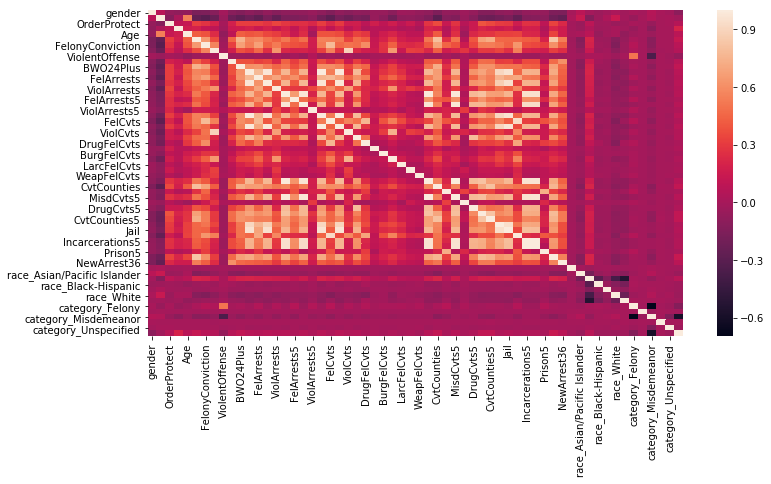

In [147]:
fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)
sns.heatmap(df.corr())
plt.show()

We ended up with 49 features:<br/>
Binary Class: Gender,Housing,MisdConviction,FelonyConviction,ViolentConviction,ViolentOffense <br/>
Multi-Class: Race, Category <br/>
and other numeric features<br/>

In [79]:
#Step 5: Split Training and Testing data
train_df = df.sample(frac=0.7, replace=False)
test_df = df[~df.index.isin(train_df.index)]

In [81]:
#check if train_df and test_df overlap
len(train_df) + len(test_df) == len(df)

True

<h3>Feature Selection<h3/><br/>


In [83]:
#Declare target variable, training data and testing data
target = 'NewArrest36'
train = train_df
test = test_df

In [85]:
from sklearn.metrics import roc_curve, auc,roc_auc_score

def AUCCal(preds, truth, label_string):
    '''
    preds is an nx1 array of predictions
    truth is an nx1 array of truth labels
    label_string is text to go into the plotting label
    '''
    #1. call the roc_curve function to get the ROC X and Y values
    fpr, tpr, thresholds = roc_curve(truth, preds)
    #2. Input fpr and tpr into the auc function to get the AUC
    roc_auc = auc(fpr, tpr)
    
    if roc_auc < 0.5:
        fpr, tpr, thresholds = roc_curve(truth, -1 * preds)
        roc_auc = auc(fpr, tpr)
        
    return roc_auc    


In [128]:
feature_auc_dict = {}
for col in train.drop(target,1).columns:
    feature_auc_dict[col] = AUCCal(train[col], train[target] , col)
    
df_auc = pd.DataFrame(pd.Series(feature_auc_dict), columns = ['auc'])
df_auc['auc_approx'] = df_auc['auc'].round(3)

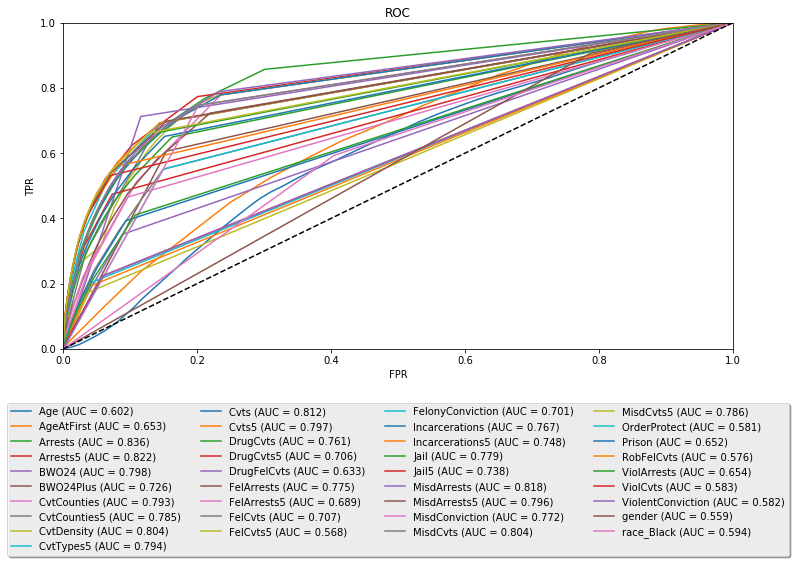

In [129]:
#with the thredshold = 0.5, we first take features with auc > 0.55
featureset_1 = list(df_auc[(df_auc.auc_approx > 0.55)].index.values)

fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)

#create a plot and set some options
for col in featureset_1:
    fpr, tpr, thresholds = roc_curve(train[target], train[col])
    roc_auc = auc(fpr, tpr)
    
    if roc_auc < 0.5:
        fpr, tpr, thresholds = roc_curve(train[target], -1 * train[col])
        roc_auc = auc(fpr, tpr)
        
    plt.plot(fpr, tpr, label = col + ' (AUC = %0.3f)' % roc_auc)
    

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc="lower right")


# Put a legend below current axis
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.0 , box.width, box.height * 1])
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
              shadow = True, ncol = 4, prop = {'size':10})

<h3>Building Models<h3/>

In [150]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


#Set up X Y
X_train = train.drop(target, 1)
Y_train = train[target]
X_test = test.drop(target, 1)
Y_test = test[target]

<h4>1st LR Model with 37 features<h4/>

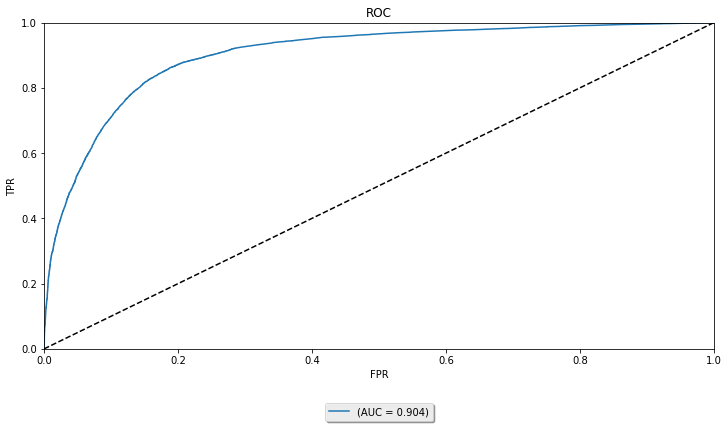

In [136]:
X_train_1 = train[featureset_1]
X_test_1 = test[featureset_1]

#Model1:Logistic Regression
logreg = LogisticRegression(C=1e30)
logreg.fit(X_train_1,Y_train)
preds_logreg = logreg.predict_proba(X_test_1)[:, 1]

#Plot
fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)

fpr, tpr, thresholds = roc_curve(Y_test,preds_logreg)
roc_auc = roc_auc_score(Y_test,preds_logreg)

plt.plot(fpr, tpr, label = '(AUC = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc="lower right")


# Put a legend below current axis
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.0 , box.width, box.height * 1])
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
              shadow = True, ncol = 4, prop = {'size':10})

In [152]:
print(classification_report(Y_test,logreg.predict(X_test_1)))

             precision    recall  f1-score   support

          0       0.84      0.88      0.86     17801
          1       0.81      0.75      0.78     12155

avg / total       0.83      0.83      0.83     29956

